# Demon Algorithm and the Ising Model HW
---

In [11]:
import numpy as np
from time import sleep
from IPython.display import clear_output
from matplotlib import pyplot as plt
from scipy.stats import linregress
%matplotlib inline

class Ising_Demon:

    def __init__(self, system_energy, L=20):

        self.L = L
        self.N = L ** 2
        self.demon_energy_dist = np.zeros(self.N)
        self.system_energy = system_energy
        self.demon_energy = 0
        self.mcs = 0
        self.system_energy_accumulator = 0
        self.demon_energy_accumulator = 0
        self.magnetization = self.N
        self.mag_accumulator = 0
        self.mag_squared_accumulator = 0
        self.accepted_moves = 0
        self.lattice = np.ones((L, L))
        self.set_energy()

        self.system_energy_list = []
        self.temperature_list = []
        self.demon_energy_list = []
        self.mag_squared_list = []

    def set_energy(self):
        """
        Sets system energy to desired level.

        :return: None
        """
        tries = 0
        E = -self.N

        while E < self.system_energy and tries < 10 * self.N:
            i = np.random.randint(self.L)
            j = np.random.randint(self.L)
            delta_E = 2 * self.lattice[i][j] * (self.lattice[(i+1)%self.L][j] + self.lattice[(i-1+self.L)%self.L][j] + self.lattice[i][((j+1)%self.L)] + self.lattice[i][((j-1+self.L)%self.L)])
            if delta_E > 0:
                E += delta_E
                new_spin = -self.lattice[i][j]
                self.lattice[i][j] = new_spin
                self.magnetization += 2*new_spin
            tries += 1

        self.system_energy = E

        return None

    def temperature(self):
        """
        Get temperature of the system.

        :return: (int) temperature of system
        """
        return 4.0 / np.log(1 + 4 / self.demon_energy_accumulator / (self.mcs * self.N))

    def reset(self, L=None, system_energy=None):
        """
        Reinitialize simulation object.

        :return: None
        """
        system_energy = system_energy if system_energy is not None else self.system_energy
        L = L if L is not None else self.L

        self.__init__(L=L, system_energy=system_energy)

        return None

    def MCS_step(self):
        """
        Iterate through all particles to complete one MCS step

        :return: None
        """

        for _ in range(self.N):
            i = np.random.randint(self.L)
            j = np.random.randint(self.L)
            delta_E = 2 * self.lattice[i][j] * (self.lattice[(i+1)%self.L][j] + self.lattice[(i-1+self.L)%self.L][j] + self.lattice[i][((j+1)%self.L)] + self.lattice[i][((j-1+self.L)%self.L)])
            if delta_E <= self.demon_energy:
                new_spin = -self.lattice[i][j]
                self.lattice[i][j] = new_spin

                self.accepted_moves += 1
                self.system_energy += delta_E
                self.demon_energy -= delta_E
                self.magnetization += 2 * new_spin

        self.mcs += 1

        self.system_energy_accumulator += self.system_energy
        self.demon_energy_accumulator += self.demon_energy
        self.mag_accumulator += self.magnetization
        self.mag_squared_accumulator += self.magnetization ** 2
        self.demon_energy_dist[int(self.demon_energy)] += 1

        self.system_energy_list.append(self.system_energy)
        self.demon_energy_list.append(self.demon_energy)
        self.mag_squared_list.append(self.magnetization ** 2)
        self.temperature_list.append(self.temperature())

        return None

    @property
    def equilibrium(self):
        """
        Calculates if the system is at equilibrium based on temperature.

        :return: True if at equilibrium else False
        """
        look_back = 100
        threshold = 0.03

        if self.mcs > 2 * look_back:
            old_mean = np.sum(self.system_energy_list[-(2*look_back):-look_back]) / look_back
            new_mean = np.sum(self.system_energy_list[-look_back: self.mcs]) / look_back
            ratio = np.abs(new_mean / old_mean) % 1

            return True if ratio <= threshold else False

        else:
            return False

    def simulate(self, simulations):
        """
        Simulate without animation.

        :param simulations: number of MCMC iterations
        :return: None
        """

        for _ in range(simulations):
            self.MCS_step()

        return None

    def animate(self, simulations):
        """
        Iterate for given MCS steps.

        :param simulations: number of MCMC iterations
        :return: None
        """
        for _ in range(simulations):
            fig = plt.figure(figsize=(12,8))
            gs = fig.add_gridspec(2,3, wspace=0.5, hspace=0.2)
            axs = gs.subplots()
            self.plot(fig, axs)
            self.MCS_step()
            sleep(0.01)
            clear_output(wait=True)

        self.plot(fig, axs)


        return None

    def plot(self, fig, ax):
        """
        Plot current lattice configuration.

        :return: None
        """

        pcm = ax[0][0].pcolormesh(self.lattice)
        fig.colorbar(pcm, ax=ax[0][0])

        ax[0][1].set(xlabel="Energy", ylabel="Temperature")
        ax[0][1].plot(self.system_energy_list, self.temperature_list, 'yo')

        ax[1][0].set(xlabel="System Energy", ylabel="Demon Energy")
        ax[1][0].plot(self.system_energy_list, self.demon_energy_list, 'ro')

        ax[1][1].set(xlabel="System Energy", ylabel="Magnetization Squared")
        ax[1][1].plot(self.system_energy_list, self.mag_squared_list, 'bo')

        ax[0][2].set(xlabel="MC Step", ylabel="Temperature")
        ax[0][2].plot(np.arange(self.mcs), self.temperature_list)

        ax[1][2].set(xlabel="MC Step", ylabel="System Energy")
        ax[1][2].plot(np.arange(self.mcs), self.system_energy_list)


        plt.show()

        return None

(a) Simulate the Ising model on a square lattice using the demon algorithm. The total number of spins N = L^2 , where L is the length of one side of the lattice. Use periodic boundary conditions as shown in Figure 15.2 so that spins in the left-hand column interact with spins in the right-hand column, etc. Do not include nonequilibrium configurations in your averages.

(b) Compute <E_d> and <M^2> as a function of E for B = 0. Choose L = 20 and run for at least 500 mcs. Use (15.10) to determine the dependence of T on E and plot E versus T.

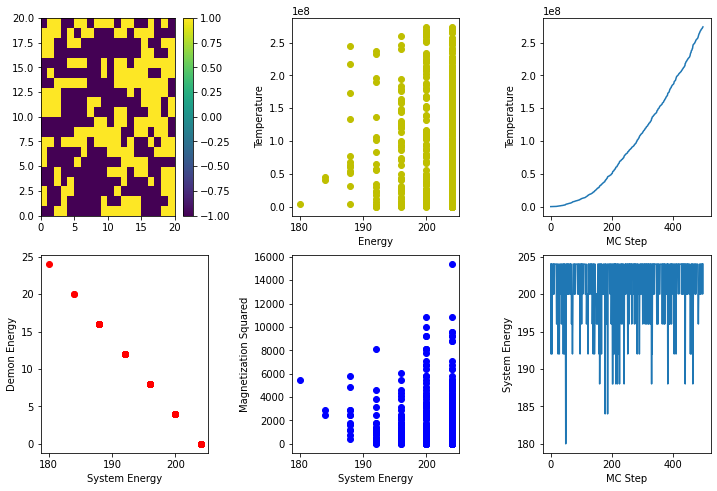

In [3]:

MCS_steps = 500
L = 20
system_energy = (L**2) // 2
model = Ising_Demon(system_energy=system_energy, L=L)
model.animate(simulations=MCS_steps)

(c) Repeat the simulations in part (b) for L = 20. Run until your averages are accurate to within a few percent. Describe how the energy versus temperature changes with lattice size.

---
Answer: Simulation run until mean system energy for most recent 100 MC steps does not vary more than 0.3% from the 100 preceding MC steps.
Temperature at equilibrium appears to scale linearly with lattice size.


In [28]:
lattice_sizes = np.linspace(10, 50, 20, dtype=np.int8)
time_to_eq = []
temp_at_eq = []

model = Ising_Demon(system_energy=system_energy, L=10)
for size in lattice_sizes:
    system_energy = (size**2) // 2
    model.reset(system_energy=system_energy, L=size)

    while not model.equilibrium:
        model.MCS_step()
    time_to_eq.append(model.mcs)
    temp_at_eq.append(model.temperature())

<ipython-input-11-164fc2fbf9f6>:62: RuntimeWarning: divide by zero encountered in double_scalars
  return 4.0 / np.log(1 + 4 / self.demon_energy_accumulator / (self.mcs * self.N))


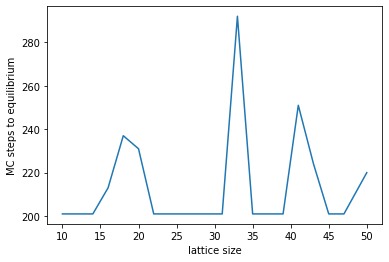

In [29]:
plt.xlabel("lattice size")
plt.ylabel("MC steps to equilibrium")
plt.plot(lattice_sizes, time_to_eq)
plt.show()

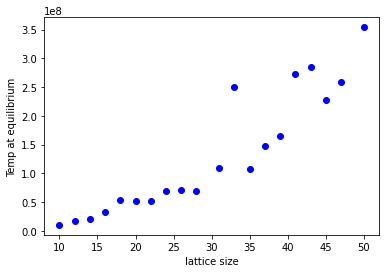

In [30]:
plt.xlabel("lattice size")
plt.ylabel("Temp at equilibrium")
plt.plot(lattice_sizes, temp_at_eq, 'bo')
plt.show()

(d) Modify your program to make “snapshots” of the spin configurations. Describe the nature of the configurations at different energies or temperatures. Are they ordered or disordered? Are there domains of up or down spins?

---
Answer: At all observed temperatures and energies, the configurations appear to be disordered. There are distinct domains of up and down spins at each time step but their specific location does not stay constant with time.

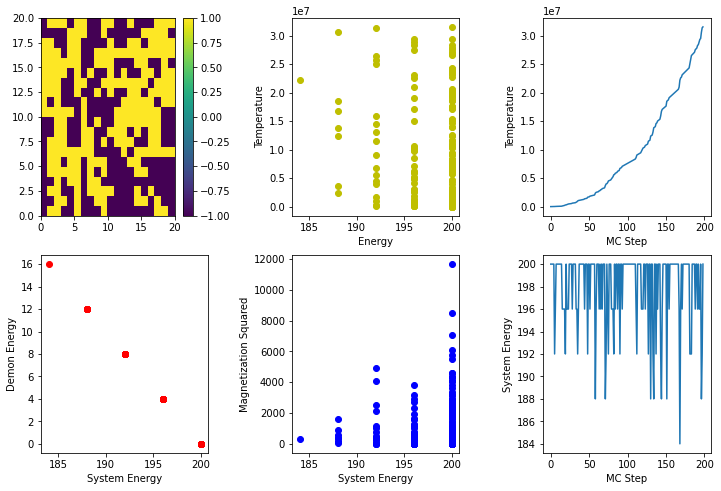

In [31]:
MCS_steps = 200
L = 20
system_energy = (L**2) // 2
model = Ising_Demon(system_energy=system_energy, L=L)
model.animate(simulations=MCS_steps)